# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet50

print(tf.__version__)
print(tf.executing_eagerly())

2.4.0
True


## Функции загрузки данных

In [3]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('dogs-vs-cats-redux-kernels-edition/train/train/*.jpg')
test_files = glob('dogs-vs-cats-redux-kernels-edition/test/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    #return vgg16.preprocess_input(img)  # предобработка для VGG16
    return resnet50.preprocess_input(img)

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

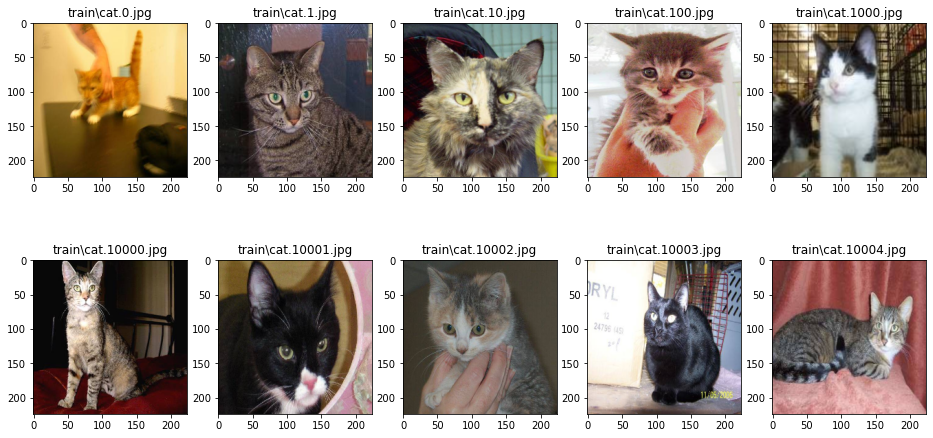

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [5]:
# base_model - объект класса keras.models.Model (Functional Model)
#base_model = vgg16.VGG16(weights='imagenet',
#                         include_top=False,
#                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model = resnet50.ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [6]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Добавляем полносвязный слой

In [7]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [8]:
model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## Компилируем модель и запускаем обучение

In [9]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [10]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 15s 673ms/step - loss: 0.4797 - accuracy: 0.7732 - val_loss: 0.1758 - val_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 3s 332ms/step - loss: 0.1827 - accuracy: 0.9382 - val_loss: 0.1212 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 3s 342ms/step - loss: 0.1489 - accuracy: 0.9589 - val_loss: 0.0428 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 4s 369ms/step - loss: 0.1376 - accuracy: 0.9467 - val_loss: 0.0360 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 4s 423ms/step - loss: 0.0655 - accuracy: 0.9850 - val_loss: 0.0344 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 5s 500ms/step - loss: 0.0567 - accuracy: 1.0000 - val_loss: 0.0291 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 6s 608ms/step - loss: 0.1055 - accuracy: 0.9677 - val_loss: 0.0300 - val_accuracy: 1.000

10/10 [==============================] - 35s 4s/step - loss: 0.0739 - accuracy: 0.9813 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 59/100
10/10 [==============================] - 27s 3s/step - loss: 0.0630 - accuracy: 0.9846 - val_loss: 0.0328 - val_accuracy: 1.0000
Epoch 60/100
10/10 [==============================] - 28s 3s/step - loss: 0.0542 - accuracy: 0.9910 - val_loss: 0.0323 - val_accuracy: 1.0000
Epoch 61/100
10/10 [==============================] - 32s 3s/step - loss: 0.0784 - accuracy: 0.9738 - val_loss: 0.0327 - val_accuracy: 1.0000
Epoch 62/100
10/10 [==============================] - 38s 4s/step - loss: 0.0794 - accuracy: 0.9859 - val_loss: 0.0326 - val_accuracy: 1.0000
Epoch 63/100
10/10 [==============================] - 41s 4s/step - loss: 0.0648 - accuracy: 0.9914 - val_loss: 0.0330 - val_accuracy: 1.0000
Epoch 64/100
10/10 [==============================] - 35s 4s/step - loss: 0.0951 - accuracy: 0.9908 - val_loss: 0.0339 - val_accuracy: 1.0000
Epoch 65/100
10/10 

In [11]:
model.save('cats-dogs-resnet50.hdf5')

## Предсказания на проверочной выборке

In [103]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

In [102]:
pred = test_pred.flatten()
pred

array([9.9973601e-01, 1.6846118e-04, 3.2086624e-05, ..., 9.9996781e-01,
       9.3002593e-05, 3.0255290e-08], dtype=float32)

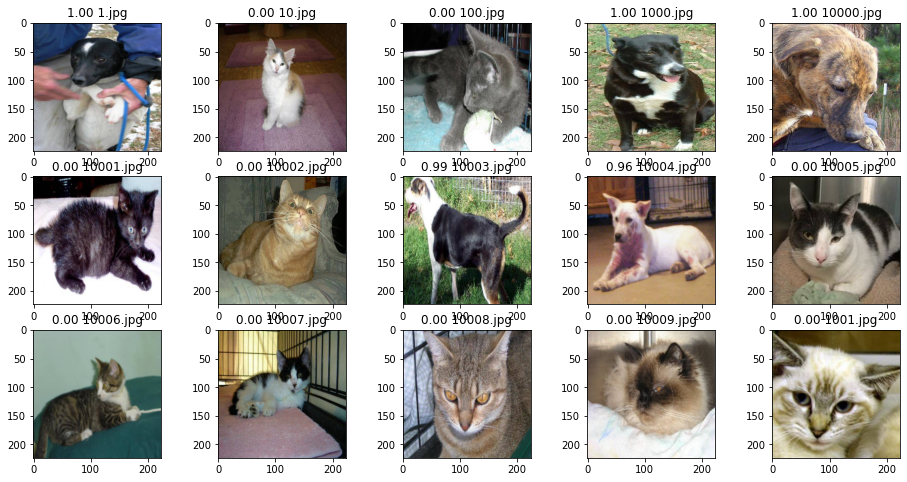

In [101]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:15], test_pred[:15]), 1):
    subplot = fig.add_subplot(3, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [14]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))